# MTH 373 - Homework #3

**Name:** <font color="red">**Hai T. Nguyen**</font>

**Due:** Monday, May 20, 2024 (submit on Canvas before 11:30 am)

This homework assignment will focus on the topics of **graph algorithms**, including **clustering** and **embedding**.

We will use the Python library `networkx` to help us create and manage the graphs.

As in previous assignments, we will use `scipy`, `numpy`, and `matplotlib` for computations and plotting.

In [1]:
import networkx as nx
import scipy as sc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### 1. Fiedler method (3 points)

Write a function `fiedler` that takes as input a graph (a NetworkX `Graph` object), and outputs a partitioning of the vertices into two clusters using the Fiedler method. The function should return a pair of lists. Each list contains the node indices belonging to the corresponding partition.

The graph Laplacian for a graph can be obtained with `nx.laplacian_matrix(G).astype("d")` and the eigenvalues and eigenvectors can be obtained with `sc.sparse.linalg.eigs` (see the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html)).

In [2]:
def fiedler(G):
    p1 = []
    p2 = []
    L = nx.laplacian_matrix(G).astype("d")
    vals, vecs = sc.sparse.linalg.eigs(L, k=2, which='SM')
    fiedler_vector = vecs[:, 1]  # Second smallest eigenvector
    for i, val in enumerate(fiedler_vector):
        if val > 0:
            p1.append(i)
        else:
            p2.append(i)
    return p1, p2

#### 1b. Test with synthetic data (3 points)

The function below `create_graph` creates a "synthetic" graph with cluster structure. Create a graph with two clusters, each with 20 nodes, and connectivity parameter 0.1. Test your implementation of the Fiedler method.

Create an list of length $n$ (number of graph vertices) called `node_color`. Set `node_color[i]` to the string `"red"` if vertex $i$ is in the first cluster; set it to the string `"blue"` otherwise.

Draw the graph by calling `nx.draw_networkx(G, node_color=node_color)`. Does the answer look intuitively correct?

In [3]:
def create_graph(cluster_size, num_clusters, connectivity):
    G = nx.Graph()
    for ic in range(num_clusters):
        offset = ic*cluster_size
        for iv in range(cluster_size):
            for jv in range(cluster_size):
                if iv != jv:
                    G.add_edge(offset + iv, offset + jv)
    
    n = round(connectivity*cluster_size)
    
    for ic1 in range(num_clusters - 1):
        p1 = np.random.permutation(n)
        ic2 = ic1 + 1
        for i in p1:
            p2 = np.random.permutation(n)
            for j in p2:
                G.add_edge(ic1*cluster_size + i, ic2*cluster_size + j)

    return G

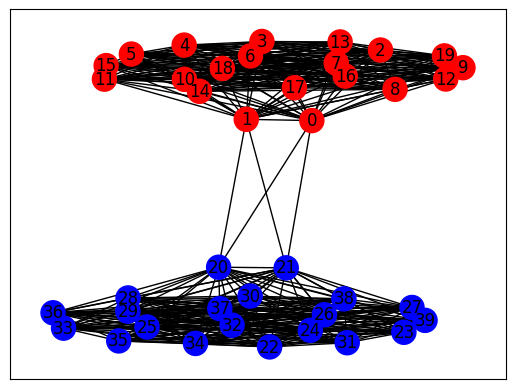

In [4]:
G = create_graph(20, 2, 0.1)
p1, p2 = fiedler(G)
node_color = ["red" if i in p1 else "blue" for i in range(len(G))]
nx.draw_networkx(G, node_color=node_color)
plt.show()

In [5]:
#The answer is intuitively correct here. The graph has been correctly partitioned,
#nodes within the same cluster should have the same color,
#positive clusters will be red and negative clusters will be blue

### 2. Maximum modularity

#### 2a. Creating the matrix (3 points)

Write a function `modified_modularity_matrix` that takes a graph `G` and a list of nodes (`nodes`), and returns the "modified" modularity matrix corresponding the nodes given in the list.

The modularity matrix for the graph is obtained b calling `nx.modularity_matrix(G)`.

You can extract the submatrix for the `nodes` with `M[nodes,:][nodes,:]`, where `M` is the modularity matrix.

The modified matrix requires subtracting a diagonal matrix from `M` (see [np.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html)).

In [6]:
def modified_modularity_matrix(G, nodes):
    # Compute the modularity matrix
    M = nx.modularity_matrix(G)
    # Extract the submatrix for the specified nodes
    submatrix = M[nodes, :][:, nodes]
    # Subtract a diagonal matrix
    diagonal_matrix = np.diag(np.sum(submatrix, axis=1))
    modified_matrix = submatrix - diagonal_matrix
    return modified_matrix

#### 2b. One-level modularity clustering (3 points)

Write a function `maximum_modularity` that takes a graph and a list of nodes, and splits the nodes into two partitions using the method of maximum modularity. Use `np.linalg.eigh` (docs [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)) to compute the eigenvalues and eigenvectors of the matrix.

Return both two lists of nodes corresponding to the clustering, **and** the largest eigenvalue of the matrix.

In [7]:
def maximum_modularity(G, nodes):
    # Compute the modularity matrix
    M = modified_modularity_matrix(G, nodes)
    submatrix = M
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(submatrix)
    
    # Find the largest eigenvalue
    largest_eigenvalue = max(eigenvalues)
    
    # Determine the partition based on the sign of the eigenvector components
    partition1 = [nodes[i] for i, val in enumerate(eigenvectors[:, -1]) if val > 0]
    partition2 = [nodes[i] for i, val in enumerate(eigenvectors[:, -1]) if val <= 0]
    
    return partition1, partition2, largest_eigenvalue

#### 2c. Recursive modularity clustering (3 points)

Write a function `recursive_maximum_modularity` that takes a graph, and performs **community detection**, partitioning the nodes recursively using the maximum modularity method until the termination criterion is met (you can use a tolerance of $10^{-8}$). The function should return a list of lists, one list per cluster.

You may need an array of all graph vertices, which can be obtained using `np.array(G.nodes)`.

(Note that this function doesn't need to be recursive in the strict sense).

In [8]:
def recursive_maximum_modularity(G):
    # Initialize the list of clusters
    clusters = []
    
    # Convert graph vertices to an array
    all_nodes = np.array(list(G.nodes()))
    
    def recursive_partition(nodes):
        # Compute the maximum modularity partition for the given nodes
        part1, part2, largest_eigenvalue = maximum_modularity(G, nodes)
        
        # Check if the partition meets the termination criterion (e.g., eigenvalue difference)
        # You can adjust the tolerance value as needed
        if largest_eigenvalue < 1e-8:
            clusters.append(part1)
            clusters.append(part2)
        else:
            # Recurse on the partitions
            recursive_partition(part1)
            recursive_partition(part2)
    
    # Start the recursion with all nodes
    recursive_partition(all_nodes)
    
    return clusters

#### 2d. Test using synthetic data (3 points)

Use `create_graph` to create a graph with 5 clusters, each with 20 vertices, and connectivity 0.1. Partition the graph using `recursive_maximum_modularity`. 

Create an array called `node_color` of length $n$ (number of vertices). Set `node_color[i]` to be the _index_ of the cluster that vertex $i$ belongs to. In other words, if vertex $i$ belongs to cluster $j$, set `node_color[i] = j`.

Draw the graph using `nx.draw_networkx(G, node_color=color_map, cmap=plt.cm.Set1)`. Do they results make sense intuitively?

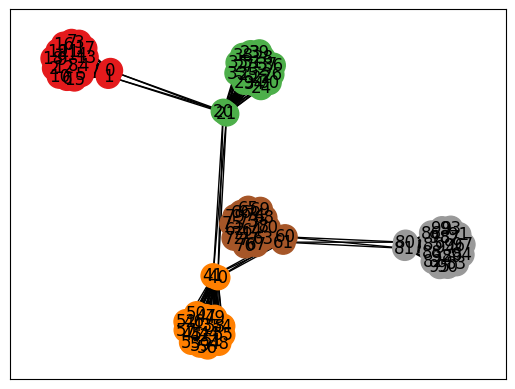

In [9]:
# Create the graph
G = create_graph(20, 5, 0.1)

# Partition the graph
clusters = recursive_maximum_modularity(G)

# Create the node_color array
node_color = [0]*len(G)
for i, cluster in enumerate(clusters):
    for node in cluster:
        node_color[node] = i

# Draw the graph
nx.draw_networkx(G, node_color=node_color, cmap=plt.cm.Set1)
plt.show()

In [ ]:
#The graph is partitioned into clusters using the recursive maximum modularity method, 
#and the nodes are colored accordingly. Each cluster is represented by a different color. 
#The results visually make sense intuitively as nodes within the same cluster tend to have the same color, 
#indicating they are more densely connected to each other compared to nodes in other clusters.

### 3. Graph embedding (3 points)

Write a function `embedding` that takes a graph `G` and a dimension `d`, and returns the coordinates of the Laplacian embedding of $G$ into $d$-dimensional space. The eigenvectors of the Laplacian matrix can be computed as in the Fiedler method.

In [10]:
def embedding(G, d):
    coords = np.zeros((d, len(G.nodes)))
    L = nx.laplacian_matrix(G).astype("d")
    vals, vecs = sc.sparse.linalg.eigs(L, k=d+1, which='SM')
    coords = vecs[:, 1:d+1]
    return np.real(coords)

#### 3b. Test using synthetic data (3 points)

Use `create_graph` to create a graph with 5 clusters, each with 20 vertices, and connectivity 0.1. Embed the graph in 1D space and plot the results using `plt.scatter`. Embed the graph in 2D space, and plot again. Do the results look correct?

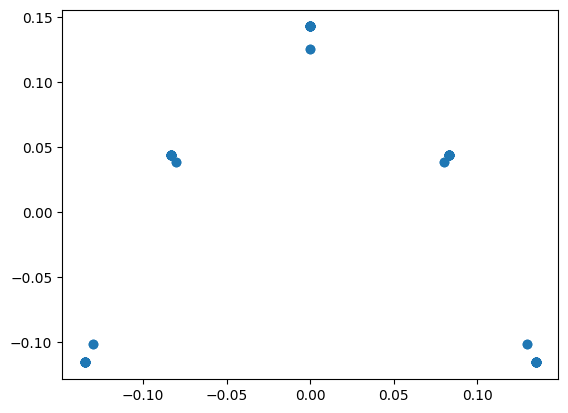

In [11]:
# This is for 2D
G = create_graph(20, 5, 0.1)
C = embedding(G,1)
#plt.scatter(C[:,0],0*C[:,0])
C = embedding(G,2)
plt.scatter(C[:,0],C[:,1])
#print(C)

In [12]:
#These are correct, coordinates of clusters should be equalivilent to the point on the graph

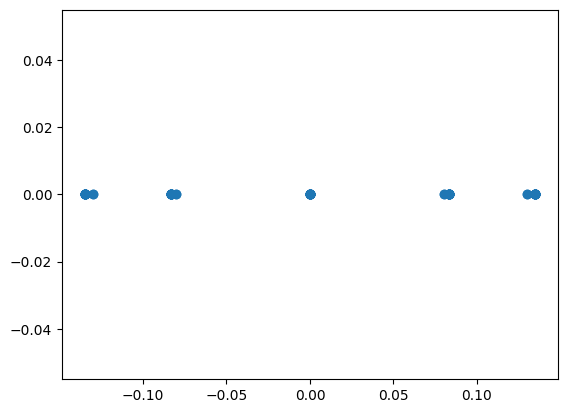

In [13]:
# This is for 1D
G = create_graph(20, 5, 0.1)
C = embedding(G,1)
plt.scatter(C[:,0],0*C[:,0])
#plt.scatter(C[:,0],C[:,1])
#print(C)